# Deconstructing the Fitbit Sleep Score

In this project I am going to use different Machine Learning models to try and get a better understanding of how Fitbit computes the sleep score that it provides to its users.

First, I will import some sleep score data and visualise the data in different ways. Afterwards, I will apply Machine Learning Models to the data in order to find, and ultimately be able to predict, patterns.

## Import Libraries and Data

In [149]:
# Import all relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import statsmodels.api as sm

In [3]:
# Import the sleep data
sleep_score = pd.read_csv('sleep_score.csv')
sleep_stats = pd.read_csv('sleep_stats.csv')

## Inspect DataFrames

In [6]:
# Inspect the sleep score DataFrame
sleep_score.head()

,timestamp,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2020-07-02T06:23:30Z,86,21,22,43,90,59,0.059426
1,2020-07-01T06:03:30Z,77,21,21,35,125,61,0.091463
2,2020-06-30T05:57:00Z,78,20,22,36,79,60,0.058201
3,2020-06-29T06:05:00Z,76,20,22,34,75,61,0.067885
4,2020-06-28T09:20:30Z,82,20,20,42,126,62,0.097103


In [7]:
# Inspect the sleep stats DataFrame
sleep_stats.head()

,Sleep,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
1,2020-07-01 10:05PM,2020-07-02 6:23AM,456,42,37,498,94,271,91
2,2020-06-30 9:43PM,2020-07-01 6:03AM,412,88,32,500,79,208,125
3,2020-06-29 10:03PM,2020-06-30 5:57AM,412,61,26,473,91,242,79
4,2020-06-28 11:24PM,2020-06-29 6:05AM,342,59,26,401,71,196,75


Something went wrong with the import here. The first row should clearly be the column headers. Let's fix that.

In [151]:
sleep_stats.columns = sleep_stats.iloc[0]
sleep_stat = sleep_stats.drop(sleep_stats.index[0])

In [12]:
# Check for NaNs
sleep_score.isna().any(), sleep_stat.isna().any()

(timestamp                False
 overall_score            False
 composition_score        False
 revitalization_score     False
 duration_score           False
 deep_sleep_in_minutes    False
 resting_heart_rate       False
 restlessness             False
 dtype: bool,
 0
 Start Time              False
 End Time                False
 Minutes Asleep          False
 Minutes Awake           False
 Number of Awakenings    False
 Time in Bed             False
 Minutes REM Sleep        True
 Minutes Light Sleep      True
 Minutes Deep Sleep       True
 dtype: bool)

The sleep_stat DataFrame has NaNs and we will drop the rows with missing values.

In [14]:
# Drop rows with missing values
sleep_stat.dropna(axis=0, inplace=True)

## Merge the two DataFrames

I want to be able to merge the two DataFrames on the date. As of new there are slight differences in how the times are displayed. The sleep_stat DataFrame has both starting and ending dates but what we care about are ending dates (those are always the dates on which the sleep score is provided). I will drop the beginning date column, transform the dates so that they are in the same format across the two DataFrames and then merge the DataFrames on the date.

In [ ]:
# Drop start time column from sleep_stat
sleep_stat.drop(columns='Start Time', inplace=True)

In [22]:
# Separate date into new column
sleep_stat['Date'] = sleep_stat['End Time'].apply(lambda x: x[:10])
sleep_score['Date'] = sleep_score.timestamp.apply(lambda x: x[:10])

In [24]:
# Merge the two DataFrames
joined_sleep = sleep_stat.merge(sleep_score, on='Date', how='left')
joined_sleep.head()

,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Date,timestamp,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2020-07-02 6:23AM,456,42,37,498,94,271,91,2020-07-02,2020-07-02T06:23:30Z,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,2020-07-01 6:03AM,412,88,32,500,79,208,125,2020-07-01,2020-07-01T06:03:30Z,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2020-06-30 5:57AM,412,61,26,473,91,242,79,2020-06-30,2020-06-30T05:57:00Z,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,2020-06-29 6:05AM,342,59,26,401,71,196,75,2020-06-29,2020-06-29T06:05:00Z,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,2020-06-28 9:20AM,530,108,39,638,98,305,127,2020-06-28,2020-06-28T09:20:30Z,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In order to get this merged DataFrame in an order that I prefer, I will drop the End Time and the timestamp column and rearrange the columns so that the Date is the first column.

In [33]:
# Drop redundant columns
sleep_data = joined_sleep.drop(columns=['End Time', 'timestamp'])

In [152]:
# Get a list of the columns
cols = sleep_data.columns.tolist()

In [153]:
# Rearrange the columns
new_cols = [cols[7]] + cols[:7] + cols[8:]

In [43]:
# Reorder the DataFrame
sleep_new = sleep_data[new_cols]
sleep_new.head()

,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score,composition_score,revitalization_score,duration_score,deep_sleep_in_minutes,resting_heart_rate,restlessness
0,2020-07-02,456,42,37,498,94,271,91,86.0,21.0,22.0,43.0,90.0,59.0,0.059426
1,2020-07-01,412,88,32,500,79,208,125,77.0,21.0,21.0,35.0,125.0,61.0,0.091463
2,2020-06-30,412,61,26,473,91,242,79,78.0,20.0,22.0,36.0,79.0,60.0,0.058201
3,2020-06-29,342,59,26,401,71,196,75,76.0,20.0,22.0,34.0,75.0,61.0,0.067885
4,2020-06-28,530,108,39,638,98,305,127,82.0,20.0,20.0,42.0,126.0,62.0,0.097103


In [47]:
# Drop the one row with remaining NaNs
sleep = sleep_new.dropna(axis=0)

## Visualise the data

Before I continue with some statistics and Machine Learning I want to visualise the data.

In [150]:
# Find spread of sleep score values
spread = int(max(sleep.overall_score) - min(sleep.overall_score))
spread

32

Text(0.5, 1.0, 'Sleep Score Distribution')

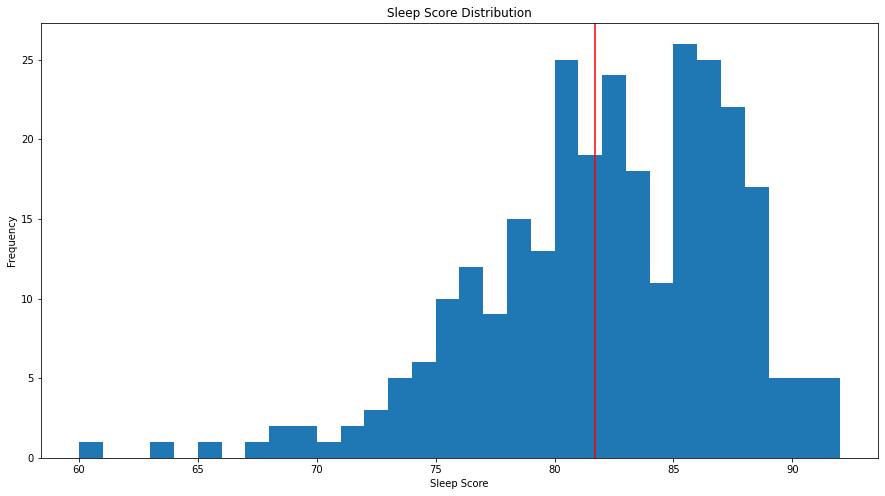

In [63]:
# Plot sleep score histogram
plt.figure(figsize=(15,8))
plt.hist(sleep.overall_score, bins=spread)
plt.axvline(sleep.overall_score.mean(), color='r', label='Average Sleep Score')
plt.xlabel('Sleep Score')
plt.ylabel('Frequency')
plt.title('Sleep Score Distribution')

It appears as though the sleep scores have a multimodal (almost bimodal) distribution and are skewed to the left. Next, I want to have a look at the time series of the sleep scores and the components provided in the Fitbit App. Because the Fitbit App gives you both percentages and absolute values I will compute the percentages of sleep stages and being awake first. I will focus on time in bed and minutes spend in each sleep stage in this part of the analysis.

## Obtain App Data

In [85]:
# Create DataFrame that represents what the App provides to users
app_cols = sleep.columns[:9]
app_cols

Index(['Date', 'Minutes Asleep', 'Minutes Awake', 'Number of Awakenings',
       'Time in Bed', 'Minutes REM Sleep', 'Minutes Light Sleep',
       'Minutes Deep Sleep', 'overall_score'],
      dtype='object')

In [107]:
# Create a DataFrame with these columns
app_data = sleep[app_cols]
app_data.head()

,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,2020-07-02,456,42,37,498,94,271,91,86.0
1,2020-07-01,412,88,32,500,79,208,125,77.0
2,2020-06-30,412,61,26,473,91,242,79,78.0
3,2020-06-29,342,59,26,401,71,196,75,76.0
4,2020-06-28,530,108,39,638,98,305,127,82.0


In [110]:
# Convert columns to floats
app_data[app_cols[1:8]] = app_data[app_cols[1:8]].astype(float)
app_data.head()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Date,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
0,2020-07-02,456.0,42.0,37.0,498.0,94.0,271.0,91.0,86.0
1,2020-07-01,412.0,88.0,32.0,500.0,79.0,208.0,125.0,77.0
2,2020-06-30,412.0,61.0,26.0,473.0,91.0,242.0,79.0,78.0
3,2020-06-29,342.0,59.0,26.0,401.0,71.0,196.0,75.0,76.0
4,2020-06-28,530.0,108.0,39.0,638.0,98.0,305.0,127.0,82.0


## Visualise Relationships between Independent Variables and Sleep Score

Befor looking into Multiple Linear Regression I want to visualise the relationships between all independent variables and the overall sleep score to get a sense of what some of the relationships may look like. I will visualise the relationships using scatter plots.

In [181]:
# Define a function to plot the scatterplots of the relationships between all independent variables and the dependent
# variable
def plot_relationships(df, num_cols):
    variables = df.columns
    # This function assumes that the dependent variable is in the last column
    dep_var = variables[-1]
    ind_var = variables[:-1]
    figs = len(dep_var)
    num_cols = num_cols
    num_rows = round(figs / num_cols) + 1
    fig = 1
    plt.figure(figsize=(20,30))
    # Loop through all independent variables and create the scatter plot
    for i in ind_var:
        pltfignums = [str(num_rows), str(num_cols), str(fig)]
        pltfig = int(''.join(pltfignums))
        plt.subplot(pltfig)
        plt.scatter(df[i], df[dep_var])
        plt.xlabel(str(i))
        plt.ylabel(str(dep_var))
        fig +=1

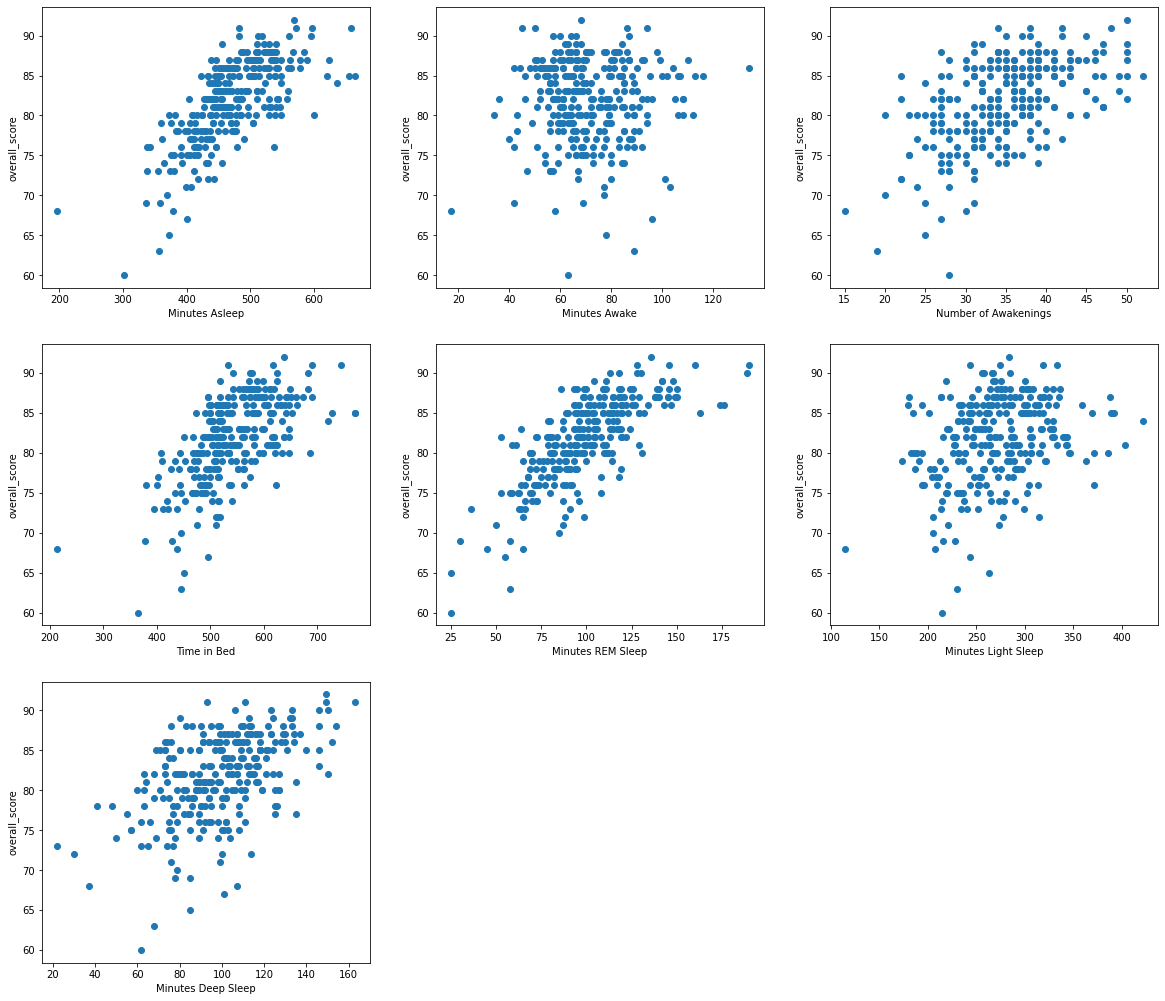

In [180]:
# Plot the relationships of all independent variables with the depedent variable
plot_relationships(app_data[app_data.columns[1:]], 3)

Variables such as Minutes Asleep, Time in Bed and Minutes REM Sleep clearly have strong positive relationships with the overall sleep score. To confirm, let's quickly have a look at the correlation matrix.

In [121]:
# Let's have a quick look at the correlations between these
app_data[app_cols[1:]].corr()

,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,overall_score
Minutes Asleep,1.000000,0.489912,0.715422,0.980407,0.629681,0.756920,0.511837,0.699627
Minutes Awake,0.489912,1.000000,0.360927,0.652037,0.160597,0.428132,0.303564,0.033523
Number of Awakenings,0.715422,0.360927,1.000000,0.703762,0.403212,0.528979,0.446308,0.527397
Time in Bed,0.980407,0.652037,0.703762,1.000000,0.583927,0.755038,0.513741,0.616046
Minutes REM Sleep,0.629681,0.160597,0.403212,0.583927,1.000000,0.083341,0.433558,0.745308
Minutes Light Sleep,0.756920,0.428132,0.528979,0.755038,0.083341,1.000000,-0.035149,0.287346
Minutes Deep Sleep,0.511837,0.303564,0.446308,0.513741,0.433558,-0.035149,1.000000,0.503672
overall_score,0.699627,0.033523,0.527397,0.616046,0.745308,0.287346,0.503672,1.000000


The sleep score has the highest correlation with Minutes REM sleep. This could be an early inidcator of the importance of REM sleep. Furthermore, and this is important, there are patterns of high correlation between independent variables, i.e. everything that is not the overall score. This could cause issues in statistical modeling and should be handled before running any models.

One common way of testing for multicollinearity is to use Variable Inflation Factors (VIF). VIF essentially tests how strong the correlation between independent variables is by regressing every independent variable against all other independent variables. The VIF is inflated by R^2, meaning that a higher R^2 (which indicates high correlation) increases the VIF.

In [124]:
# Define a function to calculate the VIF
def calc_vif(X):
    # Create a DataFrame for the VIFs
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif

In [134]:
# Separate the independent variables
X1 = app_data.iloc[:,1:-1]

In [182]:
# Calculate the VIFs
calc_vif(X1)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Variable,VIF
0,Minutes Asleep,inf
1,Minutes Awake,inf
2,Number of Awakenings,63.181782
3,Time in Bed,inf
4,Minutes REM Sleep,inf
5,Minutes Light Sleep,inf
6,Minutes Deep Sleep,inf


As some of the values are clearly almost perfectly correlated, i.e. they can be perfectly explained by some or all other independent variables, the VIF is infinity for every independent variable apart from Number of Awakenings. 

If we think about it this makes perfect sense. Minutes Asleep, for example, can be computed as the sum of the minutes spent in REM, Light and Deep Sleep and vice versa. The only independent variable that can't be perfectly explained by the others is Number of Awakenings. This is still highly correlated with the other independent variables though. Let's start removing independent variables and recaluclating the VIF.

In [188]:
# Drop Minutes Awake, Number of Awakenings, Minutes Light Sleep and recaluclate VIFs
X2 = X1.drop(columns=['Minutes Asleep', 'Minutes Light Sleep', 'Number of Awakenings'])
calc_vif(X2)

,Variable,VIF
0,Minutes Awake,39.801097
1,Time in Bed,105.619849
2,Minutes REM Sleep,27.713683
3,Minutes Deep Sleep,28.471601


There are still high VIFs, which will make the interpretability of the coefficients and the p-values difficult. Just out of curiosity, let's run the Multiple Linear Regression and see what the results are.

In [189]:
# Store the sleep scores as the y variable
y = app_data['overall_score']

In [193]:
# Inspect the statsmodel results
X_model = sm.add_constant(X2)
est = sm.OLS(y, X_model)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          overall_score   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     198.1
Date:                Sun, 19 Jul 2020   Prob (F-statistic):           1.79e-80
Time:                        17:20:45   Log-Likelihood:                -690.68
No. Observations:                 286   AIC:                             1391.
Df Residuals:                     281   BIC:                             1410.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 56.5929      1.245     45.440      0.000      54.141      59.044
Minutes Awake         -0.1564      0.014    -11.172      0.000      -0.184      -0.129
Time in Bed            0.0453      0.004     11.419      0.000       0.038       0.053
Minutes REM Sleep      0.0799      0.008      9.543      0.000       0.063       0.096
Minutes Deep Sleep     0.0383      0.009      4.488      0.000       0.021       0.055
==============================================================================
Omnibus:                        6.839   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.715
Skew:                          -0.371   Prob(JB):                       0.0348
Kurtosis:                       3.115   Cond. No.                     4.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Because the VIFs for all variables are so high there are two things I want to have a look at. First, I'm going to run a simple regression for every independent variable in X2. Second, I'm going to standardise the values of the independent variables in X2 and see if that reduces the VIFs.

In [194]:
# Define a function to run a simple regression for every variable included in X2
def run_simple_reg(X, y):
    for i in X:
        X_simp = sm.add_constant(X[i])
        est = sm.OLS(y, X_simp)
        est2 = est.fit()
        print(est2.summary())

In [195]:
# Run the function using X2 and y
run_simple_reg(X2, y)

                            OLS Regression Results                            
Dep. Variable:          overall_score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3195
Date:                Sun, 19 Jul 2020   Prob (F-statistic):              0.572
Time:                        17:23:00   Log-Likelihood:                -882.14
No. Observations:                 286   AIC:                             1768.
Df Residuals:                     284   BIC:                             1776.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            80.9135      1.413     57.260

## Standardise the Independent Variables

All independent variables apart from Minutes Awake have statistically significant coefficients when regressed against sleep score by themselves. 

Because of the high multicollinearity and because Regression models tend to benefit from "scaled" independent variables I will scale the variables using Standard Scaler. Standard Scaler standardises the variables
to have a mean of zero and a standard deviation of 1.

In [205]:
# Scale the independent variables
scaler = StandardScaler()
X2_scaled = pd.DataFrame(scaler.fit_transform(X2), columns=X2.columns)

In [207]:
# Rerun the MLR
X2_model = sm.add_constant(X2_scaled)
est_scaled = sm.OLS(y, X2_model)
est2_scaled = est.fit()
est2_scaled.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          overall_score   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     198.1
Date:                Mon, 20 Jul 2020   Prob (F-statistic):           1.79e-80
Time:                        15:37:59   Log-Likelihood:                -690.68
No. Observations:                 286   AIC:                             1391.
Df Residuals:                     281   BIC:                             1410.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 56.5929      1.245     45.440      0.000      54.141      59.044
Minutes Awake         -0.1564      0.014    -11.172      0.000      -0.184      -0.129
Time in Bed            0.0453      0.004     11.419      0.000       0.038       0.053
Minutes REM Sleep      0.0799      0.008      9.543      0.000       0.063       0.096
Minutes Deep Sleep     0.0383      0.009      4.488      0.000       0.021       0.055
==============================================================================
Omnibus:                        6.839   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.715
Skew:                          -0.371   Prob(JB):                       0.0348
Kurtosis:                       3.115   Cond. No.                     4.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [208]:
# Compute the VIFs again
calc_vif(pd.DataFrame(X2_scaled))

,Variable,VIF
0,Minutes Awake,1.995750
1,Time in Bed,3.145178
2,Minutes REM Sleep,1.803078
3,Minutes Deep Sleep,1.411134


With the scaled values the coefficients remain unchanged and are still highly statistically significant. One major issue with accepting the standardisation as a technique to get rid of multicollinearity by reducing the VIF is that we ignore the fact that correlation between the variables has not been changed at all. All that happened is that they have been standardised. The VIF may be lower but that is about it... 